# Predizione consumo elettricità in Italia


**Pietro Pasini 0001081576**  

## Introduzione

La previsione accurata della domanda elettrica rappresenta un elemento cruciale per la gestione efficiente dei sistemi energetici senza rischiare di avere un carico insufficiente. In questo progetto, si pone l’obiettivo di sviluppare un modello predittivo in grado di stimare il carico elettrico dell’Italia in un qualsiasi momento delle successive 24 ore e in relazione alle previsioni meteo.

Per raggiungere questo scopo, ho costruito un dataset storico ad alta risoluzione, unendo i dati disponibili sul sito del gestore della trasmissione di energia in rete a quelli scaricati da un archivio meteorologico. Il set di variabili include:

- Feature calendariali (giorno dell’anno, ore di luce, festività, giorno della settimana)

- Lag storici del carico elettrico (valori registrati nel giorno e nella settimana precedenti)

- Dati meteorologici (temperature minime, massime e medie) provenienti da tre città rappresentative del territorio nazionale (Milano, Roma, Palermo)

## Setup

Importo i package necessari e configuro l'output di matplotlib

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from datetime import datetime, date
import time
import os
%matplotlib inline

In [35]:
# sono eseguiti quì tutti gli import necessari da scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

## Caricamento dei dati

Sul sito dell'ente gestore della rete elettrica Terna S.p.A. si trovano molti dati su consumo e produzione per l'Italia o per alcune Regioni.
I dati sono reperibili in formato excel al link: https://dati.terna.it/download-center#/fabbisogno/fabbisogno-italia .

Per costruzione del sito non è possibile scaricare i file tramite URI direttamente dal esso, così li ho caricati su GitHub.

I valori del fabbisogno del Paese sono disponibili a partire dal 2020 all'anno corrente, aggiornati a fine giornata.


In [36]:
YEARS = [2020, 2021, 2022, 2023, 2024, 2025]

In [37]:
data = []
DATA_DIR = "TernaData"
os.makedirs(DATA_DIR, exist_ok=True)

BASE_URL = "https://raw.githubusercontent.com/Piepaso/Italian-electricity-consumption-forecast/main/TernaData/"

for year in YEARS:
    filename = f"consumi{year}.xlsx"
    filepath = os.path.join(DATA_DIR, filename)
    
    if not os.path.exists(filepath):
        print(f"Downloading {filename} from GitHub...")
        try:
            response = requests.get(BASE_URL + filename)
            response.raise_for_status()
            
            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Successfully downloaded {filename}")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
            continue
    
    try:
        df = pd.read_excel(filepath, index_col="Date", parse_dates=["Date"])
        data.append(df)
        print(f"Loaded {filename} with shape {df.shape}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

print(f"\nLoaded {len(data)} consumption dataframes")

Loaded consumi2020.xlsx with shape (35138, 3)
Loaded consumi2021.xlsx with shape (35042, 3)
Loaded consumi2022.xlsx with shape (35042, 3)
Loaded consumi2023.xlsx with shape (35042, 3)
Loaded consumi2024.xlsx with shape (35138, 3)
Loaded consumi2025.xlsx with shape (16894, 3)

Loaded 6 consumption dataframes


Tramite questa funzione scarichiamo i dati giornalieri sulle temperature in tre città campione distribuite per l'Italia

In [38]:
def download_temperature_data(cities, years, data_dir="weather_data", save_file=False):
    
    BASE_URL = "https://www.ilmeteo.it/portale/archivio-meteo"
    
    MONTH_NAMES = {
        1: "Gennaio", 2: "Febbraio", 3: "Marzo", 4: "Aprile", 5: "Maggio", 6: "Giugno",
        7: "Luglio", 8: "Agosto", 9: "Settembre", 10: "Ottobre", 11: "Novembre", 12: "Dicembre"
    }

    COLUMNS_TO_KEEP = {
        'DATA': 'data',
        'TMEDIA °C': 'tmedia',
        'TMIN °C': 'tmin',
        'TMAX °C': 'tmax'
    }

    today = datetime.today()
    os.makedirs(data_dir, exist_ok=True)
    all_data = {city: {} for city in cities} 

    for city in cities:
        for year in years:
            filename = f"{city}_{year}.csv"
            filepath = os.path.join(data_dir, filename)
            
            if os.path.exists(filepath):
                try:
                    year_df = pd.read_csv(filepath, index_col='data', parse_dates=['data'])
                    all_data[city][year] = year_df
                    continue
                except Exception as e:
                    print(f"Error loading existing file {filepath}: {e}")
            
            # Download data if file doesn't exist or failed to load
            print(f"Downloading data for {city} {year}")
            yearly_dfs = []
            
            last_month = today.month if year == today.year else 12
            
            for month in range(1, last_month + 1):
                month_name = MONTH_NAMES[month]
                url = f"{BASE_URL}/{city}/{year}/{month_name}?format=csv"
                
                try:
                    response = requests.get(url, timeout=10)
                    response.raise_for_status()
                    
                    csv_content = io.StringIO(response.text)
                    monthly_df = pd.read_csv(csv_content, sep=';')
                    
                    monthly_df.dropna(how='all', inplace=True)

                    if not monthly_df.empty and 'DATA' in monthly_df.columns:
                        # Filter for columns that exist in the dataframe
                        existing_cols = [col for col in COLUMNS_TO_KEEP if col in monthly_df.columns]
                        df_filtered = monthly_df[existing_cols].copy()
                        
                        # Rename columns
                        df_filtered.rename(columns=COLUMNS_TO_KEEP, inplace=True)

                        # Convert 'data' column to datetime objects
                        df_filtered['data'] = pd.to_datetime(df_filtered['data'], format='%d/%m/%Y', errors='coerce')
                        df_filtered.dropna(subset=['data'], inplace=True)

                        # Convert temperature columns to numeric
                        temp_cols_renamed = ['tmedia', 'tmin', 'tmax']
                        for col in temp_cols_renamed:
                            if col in df_filtered.columns:
                                # Replace comma with dot for decimal conversion and convert to numeric
                                df_filtered[col] = df_filtered[col].astype(str).str.replace(',', '.')
                                df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

                        if not df_filtered.empty:
                            yearly_dfs.append(df_filtered)
                    else:
                        print(f"Warning: No data or 'DATA' column found for {city}, {year}-{month_name}")

                except requests.exceptions.RequestException as e:
                    print(f"Error downloading data for {city}, {year}-{month_name}: {e}")

            if yearly_dfs:
                year_df = pd.concat(yearly_dfs, ignore_index=True)
                year_df.set_index('data', inplace=True)
                all_data[city][year] = year_df
                
                if save_file:
                    try:
                        year_df.to_csv(filepath)
                        print(f"Successfully downloaded and saved data for {city} for the year {year} to {filepath}.")
                    except Exception as e:
                        print(f"Error saving data to {filepath}: {e}")
            else:
                print(f"No data compiled for {city} for the year {year}.")

    return all_data

In [39]:
CITIES   = ["Milano", "Roma", "Palermo"]
temperatures = download_temperature_data(CITIES, YEARS, save_file = False)

In [40]:
temperatures["Milano"][2025].head(3)

,tmedia,tmin,tmax
data,,,
2025-01-01,4.0,-2.0,8.0
2025-01-02,5.0,4.0,7.0
2025-01-03,6.0,1.0,11.0


## Analisi esplorativa dei dati

In [41]:
data[1].head(3)

,Total Load [MW],Forecast Total Load [MW],Bidding Zone
Date,,,
2021-12-31 23:45:00,24443.000,24487.999,Italy
2021-12-31 23:30:00,24854.000,24715.000,Italy
2021-12-31 23:15:00,25215.001,24979.999,Italy


In [42]:
data[1].tail(3)

,Total Load [MW],Forecast Total Load [MW],Bidding Zone
Date,,,
2021-01-01 00:00:00,24986.001,24701.999,Italy
NaN,NaN,NaN,NaN
Applied filters: Bidding zone is Italy; Year is 2021,NaN,NaN,NaN


I dati sono stati scaricati già filtrati per zona (in questo caso Italy) dunque la colonna "Bidding Zone" può essere eliminata.

La colonna "Forecast Total Load" rappresenta i valori predetti per conto di Terna S.p.A., questi valori saranno utili per confrontare il modello obiettivo con un modello professionale realmente utilizzato.

Inoltre si osserva che alla fine di ogni dataframe sono presenti delle righe non informative con valori nulli, possono essere rimosse con la funzione `dropna()`.

Procediamo a unire i dataframe annuali in uno unico per semplificare le operazioni.

In [43]:
data = pd.concat(data)
data.dropna(inplace=True)
data = data.drop(columns=["Bidding Zone"])
data.sort_index(inplace=True)
data.head(3)

,Total Load [MW],Forecast Total Load [MW]
Date,,
2020-01-01 00:00:00,24300.0,24502.999
2020-01-01 00:15:00,23948.0,24401.000
2020-01-01 00:30:00,23620.0,24127.000


Il valore della domanda elettrica è stato registrato ogni quarto d'ora (granularità quindicinale), dunque sono presenti 4 righe per ogni ora e 96 per ogni giorno. Si possono selezionare le righe con queste distanze per ridurre la granularita del dataset.

In [44]:
data[3::4].head(3)

,Total Load [MW],Forecast Total Load [MW]
Date,,
2020-01-01 00:45:00,23379.0,23853.0
2020-01-01 01:45:00,22412.0,22656.0
2020-01-01 02:45:00,21053.0,21329.0


In [45]:
data[47::96].head(3)

,Total Load [MW],Forecast Total Load [MW]
Date,,
2020-01-01 11:45:00,27018.999,27781.000
2020-01-02 11:45:00,36086.000,39334.998
2020-01-03 11:45:00,37955.000,37256.000


Convertiamo gli indici in tipo datetime per poter selezionare anno, mese, giorno, ora, ...

Si verifica che siano presenti 96 * 365 = 35040 righe per gli anni completi (35136 per gli anni bisestili).

Osserviamo i dati statistici per ogni anno per capire se ci sono degli anni poco rappresentativi per via di eventi eccezionali (ad esempio per il lockdown per pandemia nel 2020 e 2021).

In [46]:
data.index = pd.to_datetime(data.index)
data.groupby(data.index.year)["Total Load [MW]"].describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2020,35136.0,34300.233955,8293.880879,17364.000,27475.75025,33234.4990,41434.00025,55509.998
2021,35040.0,36530.734069,8363.309101,18338.001,29201.50025,36087.0000,43709.25000,56584.998
2022,35040.0,35965.845123,8333.332179,17164.000,28938.00000,35412.9990,42725.00025,58203.000
2023,35040.0,34931.353076,8041.816389,17474.999,28126.75050,34234.0000,41805.00000,58651.000
2024,35136.0,35524.118656,8214.434261,18314.000,28389.00175,35064.5000,42285.25025,58004.000
2025,16892.0,34903.940262,7939.198869,19108.000,27838.75075,34385.0005,41749.25100,54113.999


Non sembrano esserci delle discrepanze evidenti dunque utilizzeremo i dati per tutti gli anni disponibili.

## Feature engeneering

### Consumo storico: 1 e 7 giorni prima

Il comportamento del carico elettrico mostra forti **correlazioni temporali**, soprattutto con i valori osservati negli stessi orari dei giorni precedenti.  
Per sfruttare questa regolarità, sono state aggiunte due feature fondamentali:

- `load_prev_day`: il carico registrato esattamente 24 ore prima
- `load_prev_week`: il carico registrato esattamente 7 giorni prima

Questi lag aiutano il modello a riconoscere pattern **giornalieri e settimanali**, che spesso si ripetono con alta stabilità nel tempo.


In [47]:
data["load_prev_day"] = data["Total Load [MW]"].shift(96)
data["load_prev_week"] = data["Total Load [MW]"].shift(96 * 7)
data.dropna(inplace=True)
data.head(3)

,Total Load [MW],Forecast Total Load [MW],load_prev_day,load_prev_week
Date,,,,
2020-01-08 00:00:00,29251.001,29500.0,24089.000,24300.0
2020-01-08 00:15:00,28798.000,29515.0,23442.001,23948.0
2020-01-08 00:30:00,28457.000,28831.0,22640.002,23620.0


### Giorni della settimana e festivi: one-hot encoding

Il carico elettrico segue schemi ricorrenti legati ai giorni della settimana: ad esempio, i consumi nei giorni feriali sono tipicamente più alti rispetto al fine settimana per via dei processi industriali e per gli ambienti di lavoro. Per catturare queste variazioni regolari, estraiamo la feature "giorno della settimana" e la codifichiamo tramite one-hot encoding, che consente al modello di distinguere chiaramente ciascun giorno senza introdurre un ordine numerico artificiale (come accadrebbe usando valori interi da 0 a 6).

In [48]:
weekdays = pd.get_dummies(data.index.weekday, prefix='weekday', drop_first=True)
weekdays.index = data.index
data = pd.concat([data, weekdays], axis=1)
data[::96].head(3)

,Total Load [MW],Forecast Total Load [MW],load_prev_day,load_prev_week,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Date,,,,,,,,,,
2020-01-08,29251.001,29500.000,24089.000,24300.000,False,True,False,False,False,False
2020-01-09,31136.999,30486.001,29251.001,22212.999,False,False,True,False,False,False
2020-01-10,31015.002,31485.000,31136.999,25324.000,False,False,False,True,False,False


Per lo stesso motivo anche nei giorni festivi occasionali influenzano il fabbisogno quindi aggiungiamo una colonna booleana anche per le feste nazionali.

In [49]:
festività = [
    "01-01",  # Capodanno
    "01-06",  # Epifania
    "04-25",  # Festa della Liberazione
    "05-01",  # Festa del Lavoro
    "06-02",  # Festa della Repubblica
    "08-15",  # Ferragosto
    "11-01",  # Ognissanti
    "12-08",  # Immacolata
    "12-25",  # Natale
    "12-26",  # Santo Stefano
]
pasque = [
    date(2020, 4, 12), date(2020, 4, 13),
    date(2021, 4, 4),  date(2021, 4, 5),
    date(2022, 4, 17), date(2022, 4, 18),
    date(2023, 4, 9),  date(2023, 4, 10),
    date(2024, 3, 31), date(2024, 4, 1),
    date(2025, 4, 20), date(2025, 4, 21),
]

def is_festività(datetime):
    d = datetime.date()
    return int(d.strftime("%m-%d") in festività or d in pasque)

data['holiday'] = data.index.map(is_festività)
data[::96].tail(3)

,Total Load [MW],Forecast Total Load [MW],load_prev_day,load_prev_week,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday
Date,,,,,,,,,,,
2025-06-23 01:00:00,28786.999,28023.0,28361.999,29101.000,False,False,False,False,False,False,0
2025-06-24 01:00:00,33523.000,34298.0,28786.999,32363.001,True,False,False,False,False,False,0
2025-06-25 01:00:00,35038.000,34448.0,33523.000,32414.999,False,True,False,False,False,False,0


### Codifica di feature cicliche

Il carico elettrico varia in modo prevedibile anche nell’arco della giornata, con picchi mattutini e serali e cali notturni. Per rappresentare questa ciclicità giornaliera, convertiamo l’orario in una variabile angolare su un cerchio (da 0 a 2π), utilizzando seno e coseno. Questo approccio evita discontinuità artificiali tra le 23:45 e le 00:00, e permette al modello di riconoscere la natura periodica del tempo all'interno della giornata.

Risulta utile utilizzare entrambe le funzioni in variabili distinte per non rendere mezzogiorno uguale alla mezzanotte.

In [50]:
data['quarter_hour_sin'] = np.sin(2 * np.pi * (data.index.hour * 4 + data.index.minute // 15) / 96)
data['quarter_hour_cos'] = np.cos(2 * np.pi * (data.index.hour * 4 + data.index.minute // 15) / 96)
data.loc[:, ['quarter_hour_sin', 'quarter_hour_cos']][::4].head(3)

,quarter_hour_sin,quarter_hour_cos
Date,,
2020-01-08 00:00:00,0.000000,1.000000
2020-01-08 01:00:00,0.258819,0.965926
2020-01-08 02:00:00,0.500000,0.866025


Lo stesso approccio può essere applicato ai giorni dell'anno.

In [51]:
data['day_of_year_sin'] = np.sin(2 * np.pi * data.index.dayofyear / 366)
data['day_of_year_cos'] = np.cos(2 * np.pi * data.index.dayofyear / 366)
data.loc[:, ['day_of_year_sin', 'day_of_year_cos']][::960].head(3)

,day_of_year_sin,day_of_year_cos
Date,,
2020-01-08,0.136906,0.990584
2020-01-18,0.304115,0.952635
2020-01-28,0.462383,0.886680


### Integrazione dei dati meteo

Una percentuale significativa del consumo elettrico nazionale è dovuta alla climatizzazione degli ambienti, sia per il raffreddamento estivo che per il riscaldamento invernale. Per tenere conto di questo effetto, associamo a ciascuna riga le temperature media, minima e massima del giorno corrispondente.

In [52]:
temperatures_list = []
for city in CITIES:
    # Concateno i dataframe annuali per la città corrente
    city_df = pd.concat([temperatures[city][year] for year in YEARS if year in temperatures[city]])
    
    # Rinomino le colonne per evitare conflitti nel merge
    city_df.rename(columns={
        'tmedia': f'tmedia_{city.lower()}',
        'tmin': f'tmin_{city.lower()}',
        'tmax': f'tmax_{city.lower()}'
    }, inplace=True)
    temperatures_list.append(city_df)

temperatures_df = pd.concat(temperatures_list, axis=1)

# Eseguo il merge tra i dati di consumo e i dati meteorologici
# Il merge viene fatto sulla data (ignorando l'orario)
data = pd.merge_asof(data, temperatures_df.sort_index(), left_index=True, right_index=True)
print(len(data) - len(data.dropna()))
data.head(3)

0


,Total Load [MW],Forecast Total Load [MW],load_prev_day,load_prev_week,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,...,day_of_year_cos,tmedia_milano,tmin_milano,tmax_milano,tmedia_roma,tmin_roma,tmax_roma,tmedia_palermo,tmin_palermo,tmax_palermo
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00,29251.001,29500.0,24089.000,24300.0,False,True,False,False,False,False,...,0.990584,1.0,0.0,2.0,6.0,2.0,13.0,10.2,7.9,13.0
2020-01-08 00:15:00,28798.000,29515.0,23442.001,23948.0,False,True,False,False,False,False,...,0.990584,1.0,0.0,2.0,6.0,2.0,13.0,10.2,7.9,13.0
2020-01-08 00:30:00,28457.000,28831.0,22640.002,23620.0,False,True,False,False,False,False,...,0.990584,1.0,0.0,2.0,6.0,2.0,13.0,10.2,7.9,13.0


## 🌞 Calcolo delle ore di luce

Per stimare l'impatto della luce naturale sui consumi (es. illuminazione artificiale), è stata aggiunta una feature binaria che indica se un certo timestamp ricade tra l’alba e il tramonto a Roma, calcolati .

⚠️ *Questa cella può essere saltata*, in quanto richiede calcoli pesanti e l’importazione di pacchetto `astral`. Inoltre, l’analisi successiva mostrerà che questa variabile ha avuto un **impatto trascurabile** sulle performance del modello.


In [53]:
skip_daylight = False

if not skip_daylight:
    from astral import LocationInfo
    from astral.sun import sun

    city = LocationInfo(name='Roma', region='Italia', timezone='Europe/Rome',
                        latitude=41.9028, longitude=12.4964)

    # Funzione per calcolare se un timestamp è in piena luce naturale
    def is_daylight(timestamp):
        s = sun(city.observer, date=timestamp.date(), tzinfo=city.timezone)
        t = timestamp.tz_localize('Europe/Rome', ambiguous=False)
        return int(s['sunrise'] <= t <= s['sunset'])

    data['daylight'] = data.index.map(is_daylight)
    data[::96].tail(3)

In [54]:
print("Abbiamo ottenuto un dataframe con ", data.shape[0], "osservazioni e", data.shape[1], "variabili.")

Abbiamo ottenuto un dataframe con  191612 osservazioni e 25 variabili.


### Preparazione per training e test

Per allenare e testare i modelli prepariamo:
- una matrice `X_*` $N\times 23$ con le osservazioni delle variabili indipendenti
- un vettore `y_*` con gli $N$ corrispondenti valori della variabile dipendente: i consumi

Suddividiamo i dati in training e test set

- i _training set_ `*_train` con i dati fino all'anno 2024
- i _test set_ `*_test` con i dati relativi al 2025

Per ciascuno estraiamo



Isoliamo anche i consumi già predetti per creare un modello fittizio di confronto.

In [55]:

forecast_Terna = data['Forecast Total Load [MW]'].copy()

y = data[["Total Load [MW]"]]
X = data.drop(columns=["Total Load [MW]", 'Forecast Total Load [MW]'])

is_train = X.index.year < 2025
X_train = X[is_train]
y_train = y[is_train]
X_test = X[~is_train]
y_test = y[~is_train]

### Scaling dei dati

I consumi elettrici, espressi in megawatt, sono dell’ordine di grandezza di **10⁵**, e molte feature (come temperature o indicatori binari) hanno scale molto più ridotte. Senza normalizzazione, queste differenze possono influenzare negativamente l’addestramento del modello, in particolare nelle reti neurali.

Per questo motivo applichiamo uno **StandardScaler** (media 0, varianza 1) sia alle feature in input (`X`) che al target (`y`), in modo da rendere il processo di ottimizzazione più stabile ed efficace.


In [56]:
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

### Funzioni per valutazione e interpretazione dei modelli

Riutilizzo la funzione `print_eval` definita nelle esercitazioni del corso, aggiungento la possibilità di utilizzare uno scaler per interpretare correttamente l'ouput normalizzato del modello.

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def print_eval(X, y, model, y_scaler=None):
    preds = model.predict(X)
    if y_scaler is not None:
        preds = y_scaler.inverse_transform(preds.reshape(-1, 1))
    mse = mean_squared_error(y, preds)
    re = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

Riprendiamo anche la funzione `plot_model_on_data` per visualizzare un grafico del modello addestrato sovrapposto ai dati

In [58]:
def plot_model_on_data(X, y, model=None, figsize=(15, 5), y_scaler=None, title="Real vs Predicted"):
    plt.figure(figsize=figsize)

    plt.plot(y.index, y.values, label="Reale", color='black', alpha=0.6)

    if model is not None:
        y_pred = model.predict(X)
        if y_scaler is not None:
            y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
        plt.plot(y.index, y_pred, label="Predetto", color='red', alpha=0.7)
        

    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Carico [MW]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Selezione automatica delle feature con regressione Lasso

Per ridurre la complessità del modello ed eliminare variabili irrilevanti o ridondanti, si applica una regressione Lasso (Linear Regression con regolarizzazione L1). Questo metodo penalizza i coefficienti delle feature meno informative, portandoli esattamente a zero.

Le colonne con coefficiente nullo sono state considerate ininfluenti e rimosse dal dataset.  
Questa procedura ha permesso di semplificare il modello, ridurre il rischio di overfitting e migliorare l'efficienza computazionale, mantenendo solo le variabili realmente utili alla previsione.


In [59]:
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X_train_scaled, y_train_scaled)

,alpha,0.001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,10000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [60]:
print_eval(X_test_scaled, y_test, model_lasso, y_scaler)

lasso_coefs = np.abs(pd.DataFrame(
    model_lasso.coef_,
    index=X_train.columns,
    columns=["Coefficiente"]
)).sort_values(by="Coefficiente")
lasso_coefs

   Mean squared error: 5.4225e+06
       Relative error: 4.87357%
R-squared coefficient: 0.91397


,Coefficiente
day_of_year_cos,0.000000
tmin_milano,0.000000
daylight,0.000000
tmedia_palermo,0.000000
tmin_roma,0.000062
tmedia_roma,0.003081
day_of_year_sin,0.014142
tmedia_milano,0.030215
tmax_milano,0.030476
tmin_palermo,0.030572


In [ ]:

skip_feature_selection = True

zero_coef_columns = lasso_coefs[lasso_coefs["Coefficiente"] == 0].index.tolist()
# Rimuovo le colonne con coefficiente zero
if zero_coef_columns and not skip_feature_selection:
    X_train = X_train.drop(columns=zero_coef_columns)
    X_test = X_test.drop(columns=zero_coef_columns)
    
    # ri-scaling delle feature per ottenere il nuovo scaler
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

In [62]:
X_train.head(3)
X_test.head(3)

,load_prev_day,load_prev_week,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday,quarter_hour_sin,quarter_hour_cos,day_of_year_sin,tmedia_milano,tmax_milano,tmedia_roma,tmin_roma,tmax_roma,tmin_palermo,tmax_palermo
Date,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,24850.000,24208.000,False,True,False,False,False,False,1,0.000000,1.000000,0.017166,4.0,8.0,7.0,3.0,13.0,9.1,16.2
2025-01-01 00:15:00,24472.999,23780.000,False,True,False,False,False,False,1,0.065403,0.997859,0.017166,4.0,8.0,7.0,3.0,13.0,9.1,16.2
2025-01-01 00:30:00,23992.999,23331.001,False,True,False,False,False,False,1,0.130526,0.991445,0.017166,4.0,8.0,7.0,3.0,13.0,9.1,16.2


## Regressione con pipline e grid search

In [63]:
model_a = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])
model_a.fit(X_train, y_train_scaled)
print_eval(X_test, y_test, model_a, y_scaler)

   Mean squared error: 5.4257e+06
       Relative error: 4.90499%
R-squared coefficient: 0.91392


In [64]:
kfold_5 = KFold(5, shuffle=True, random_state=42)

grid = {
    "poly__degree": [1, 2],
    "linreg": [LinearRegression(), Ridge(alpha=0.001), Ridge(alpha=0.01)],
}

gs = GridSearchCV(model_a, grid, cv=kfold_5)

In [65]:
skip_grid_search = True
if not skip_grid_search:
    gs.fit(X_train, y_train_scaled)
    model_a = gs.best_estimator_
    pd.DataFrame(gs.cv_results_).sort_values(by="rank_test_score").head(10)

In [66]:
model_a = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("linreg", Ridge(alpha=0.01))
])
model_a.fit(X_train, y_train_scaled)
print_eval(X_test, y_test, model_a, y_scaler)

   Mean squared error: 2.3582e+06
       Relative error: 3.28366%
R-squared coefficient: 0.96259


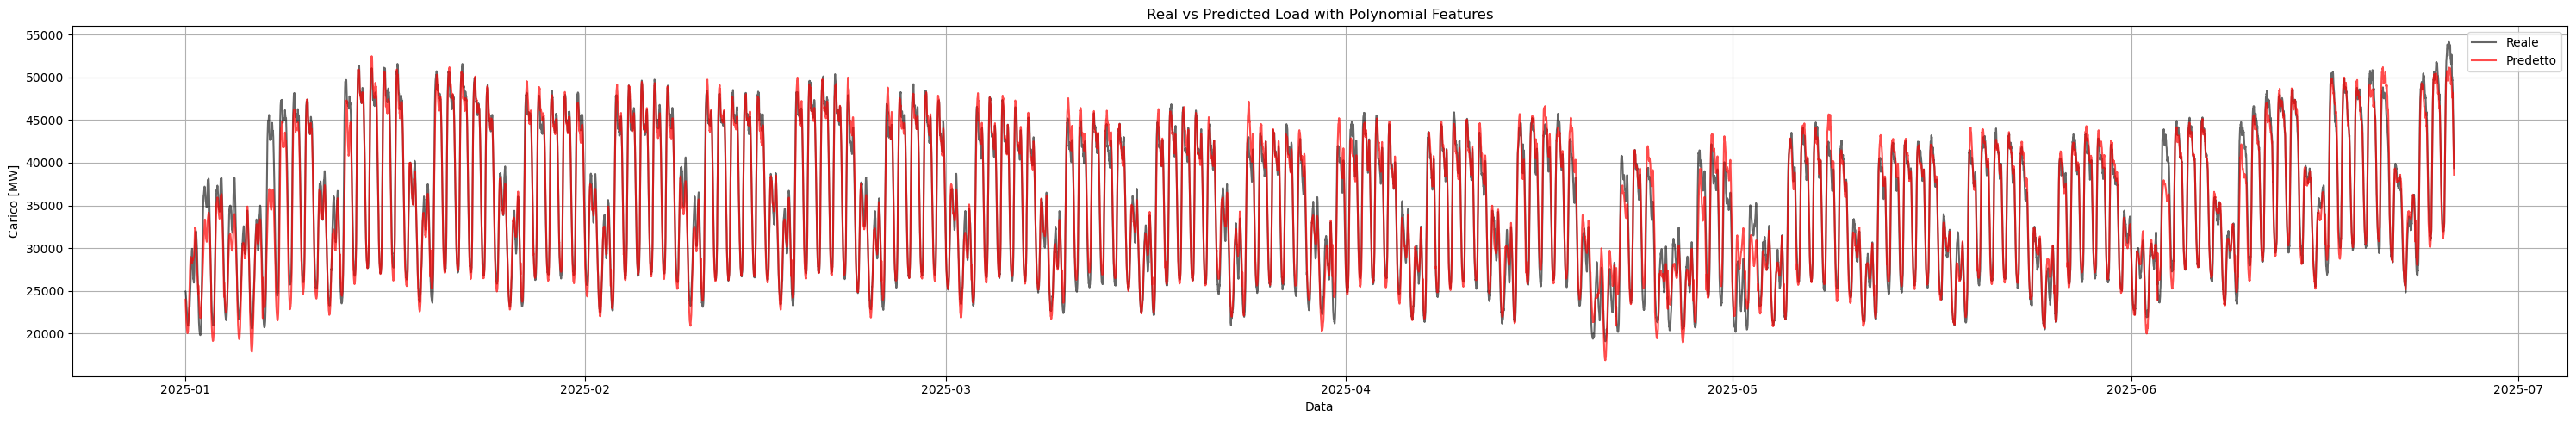

In [67]:
plot_model_on_data(X_test, y_test, model_a, figsize=(30, 5),y_scaler=y_scaler, title="Real vs Predicted Load with Polynomial Features")

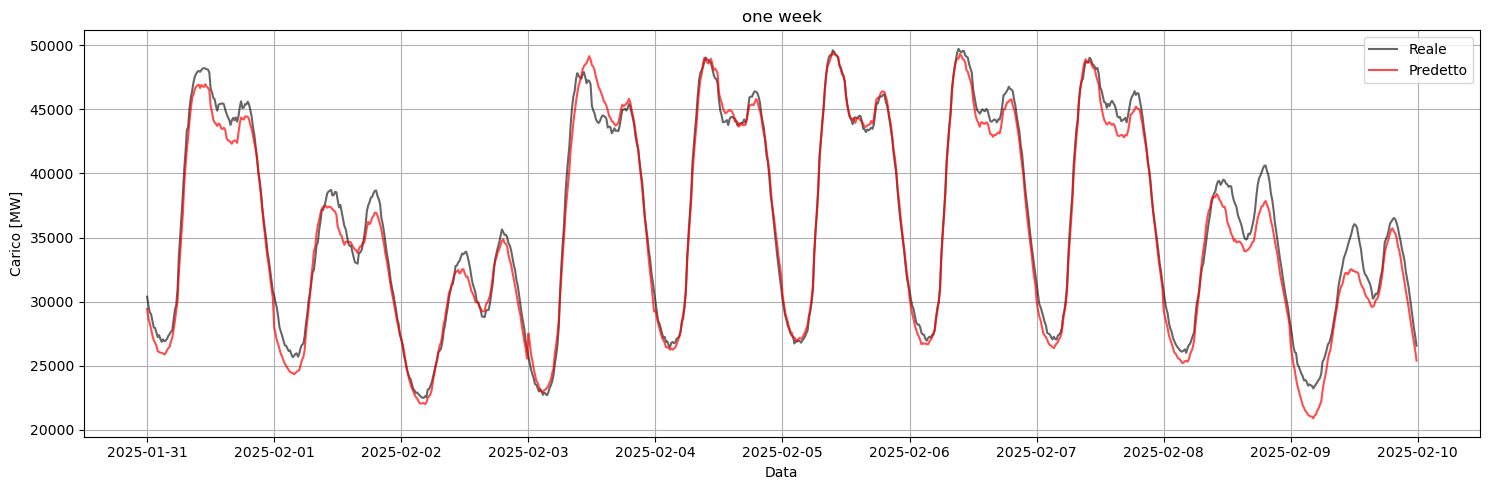

In [68]:
plot_model_on_data(X_test[2880:3840], y_test[2880:3840], model_a, y_scaler=y_scaler, title="one week")

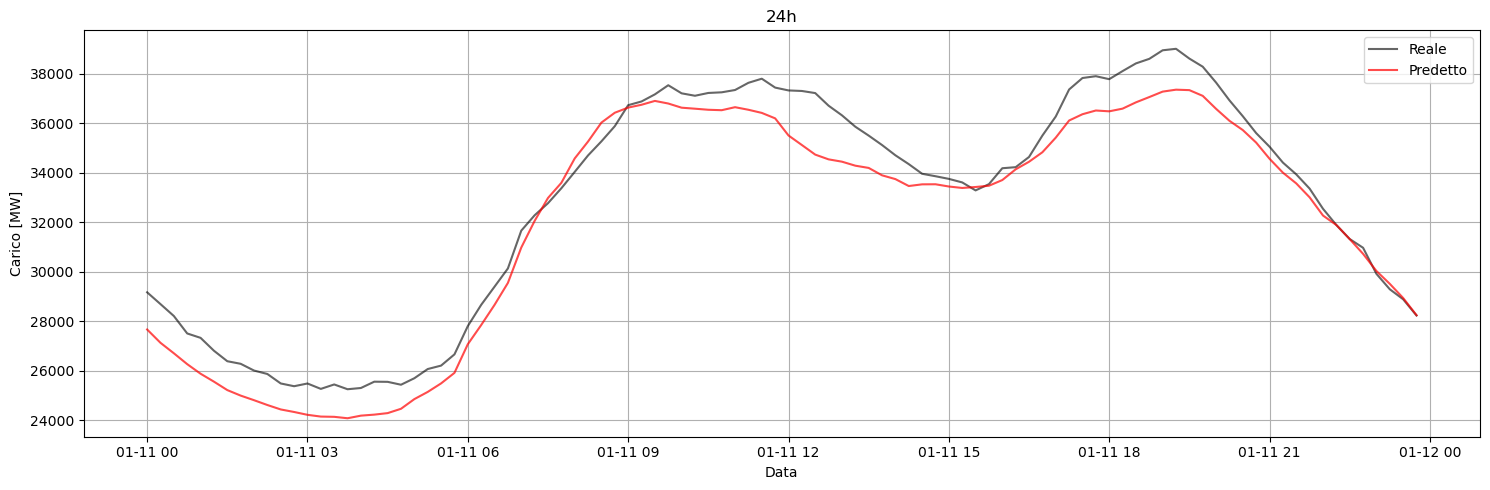

In [69]:
plot_model_on_data(X_test[960:1056], y_test[960:1056], model_a, y_scaler=y_scaler, title="24h")

## Limitazioni dei modelli classici e scelta del MLP

Il dataset include **23 variabili** e oltre **100.000 istanze**, una combinazione che rende problematico l’utilizzo di modelli classici basati su trasformazioni esplicite del feature space.

In particolare:

- L'uso di **feature polinomiali** oltre il terzo grado porta a un’esplosione combinatoria del numero di variabili con tempi di calcolo non gestibili.
- Algoritmi kernel-based come Kernel Ridge Regression, pur essendo teoricamente potenti, diventano computazionalmente proibitivi su dataset di questa scala, a causa della necessità di gestire e invertire matrici di dimensione quadratica rispetto al numero di campioni.

Per questo motivo si adotta un approccio con una **rete neurale MLP (Multi-Layer Perceptron)** implementata con `TensorFlow.Keras`, che offre numerosi vantaggi:

- Capacità di modellare **relazioni non lineari complesse** tra le feature
- Scalabilità su grandi dataset grazie all’uso di **batch training** e ottimizzatori efficienti


In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
import itertools
import time
import warnings
warnings.filterwarnings('ignore')

Ho effetuato i test su una macchina locale dotata di scheda grafica dedicata.

In [99]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


A seguire il modello con i migliori risultati ottenuto con una manipolazione manuale degli iperparametri

In [100]:
mlp_model = Sequential([
    Input((X_train.shape[1],)),
    Dense(1024, activation="relu", kernel_regularizer=l2(0.1)),
    Dense(512, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1),
])
mlp_model.compile(optimizer="adam", loss="mean_squared_error")
mlp_model.summary()

Model: "sequential_233"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1040 (Dense)              │ (None, 1024)           │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1041 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1042 (Dense)              │ (None, 32)             │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1043 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,729 (2.14 MB)

 Trainable params: 561,729 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mlp_model.fit(X_train_scaled, y_train_scaled, epochs=24, batch_size=512)

Epoch 1/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9299
Epoch 2/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0458
Epoch 3/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0432
Epoch 4/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0384
Epoch 5/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0364
Epoch 6/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0337
Epoch 7/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0313
Epoch 8/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0295
Epoch 9/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0284
Epoch 10/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0270
Epoch 11/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0267
Epoch 12/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254
Epoch 13/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0243
Epoch 14/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0235
Epoch 15/24
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [ ]:
print("Training set:")
print_eval(X_train_scaled, y_train, mlp_model, y_scaler)
print("\nTest set:")
print_eval(X_test_scaled, y_test, mlp_model, y_scaler)

Training set:
5460/5460 ━━━━━━━━━━━━━━━━━━━━ 2s 377us/step
   Mean squared error: 1.1781e+06
       Relative error: 2.32601%
R-squared coefficient: 0.98283

Test set:
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
   Mean squared error: 1.3149e+06
       Relative error: 2.47838%
R-squared coefficient: 0.97914


## Confronto con il modello di riferimento

Per valutare le prestazioni del modello MLP sviluppato, lo si confronta con un modello fittizio che restituisce le stime ufficiali pubblicate da Terna S.p.A.

In [111]:
class ForecastTernaModel:
    def __init__(self, forecast_values):
        self.forecast_train = forecast_values[is_train]
        self.forecast_test = forecast_values[~is_train]
    
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        if len(X) == len(X_train):
            return self.forecast_train.values.reshape(-1, 1)
        elif len(X) == len(X_test):
            return self.forecast_test.values.reshape(-1, 1)
        else:
            if hasattr(X, 'index'):
                matched_forecasts = forecast_Terna.loc[X.index]
                return matched_forecasts.values.reshape(-1, 1)
            else:
                raise ValueError("Cannot determine which forecast values to return")

Terna_model = ForecastTernaModel(forecast_Terna)
Terna_model.fit(X_train, y_train)

print("Training set:")
print_eval(X_train, y_train, Terna_model)
print("\nTest set:")
print_eval(X_test, y_test, Terna_model)

Training set:
   Mean squared error: 9.6678e+05
       Relative error: 2.15162%
R-squared coefficient: 0.98591

Test set:
   Mean squared error: 5.8183e+05
       Relative error: 1.65085%
R-squared coefficient: 0.99077


Il modello MLP realizzato sembra comportarsi in modo molto buono, con un R² di 0.979 sul test set, spiegando circa il 98% della varianza osservata. Tuttavia, il modello di Terna mostra una precisione superiore:

- L’errore quadratico medio sul test set è meno della metà rispetto al modello costruito.
- L’errore relativo è inferiore del 33%


## Grid Search con K-Fold per MLP Model

Per eseguire una grid search con cross-validation su un modello MLP di Keras/TensorFlow, dobbiamo:

1. Creare una funzione che costruisce il modello con parametri configurabili
2. Implementare una funzione che allena il modello e salva i risultati per ogni combinazione di paramentri della griglia
3. Definire una griglia di parametri da testare
4. Eseguire la grid search su train e test set

I parametri da testare includono:
- Numero di layer e di neuroni in ciascuno
- Regolarizzazione L2
- Numero di epoche
- Batch size

**Nota**: La grid search per modelli di deep learning richiede molto tempo.

In [76]:
def create_mlp_model(layer_sizes, optimizer="adam", l2_reg=0.1, dropout_rate=0.0):

    model = Sequential()
    model.add(Input((X_train.shape[1],)))
    
    # Add the first layer
    model.add(Dense(layer_sizes[0], activation="relu", kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Add subsequent layers
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, activation="relu"))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    
    return model

In [103]:
def grid_search_mlp(param_grid, X_train, y_train, X_test, y_test, verbose=True):
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(itertools.product(*param_values))

    results = []
    best_score = 0
    best_params = None
    best_model = None
    total_combinations = len(param_combinations)
    
    if verbose:
        print(f"Testing {total_combinations} parameter combinations...\n")
    
    for i, param_combo in enumerate(param_combinations):
        params = dict(zip(param_names, param_combo))

        if verbose:
            print(f"Combination {i+1}/{total_combinations}: {params}")
        
        try:
            start_time = time.time()
            model_params = {}
            training_params = {}
            
            for key, value in params.items():
                if key.startswith('model__'):
                    model_params[key.replace('model__', '')] = value
                else:
                    training_params[key] = value
            
            model = create_mlp_model(**model_params)
            try:
                model.fit(X_train, y_train, 
                        epochs=training_params.get('epochs', 24),
                        batch_size=training_params.get('batch_size', 512),
                        verbose=0)
                
                y_pred = model.predict(X_test, verbose=0)
                
                # Calculate test r2 (our scoring metric)
                preds = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
                mse = mean_squared_error(y_test, preds)
                re = mean_absolute_percentage_error(y_test, preds)
                r2 = r2_score(y_test, preds)
                
                # Store results
                result = {
                    'params': params.copy(),
                    'r2_score': r2,
                    'test_score': r2,
                    'training_time': time.time() - start_time
                }
                results.append(result)
                
                if r2 > best_score:
                    best_score = r2
                    best_params = params.copy()
                    best_model = model
                
                if verbose:
                    print(f"  Test r2: {r2:.6f}, Time: {result['training_time']:.2f}s\n")

            except KeyboardInterrupt:
                print("GRID SEARCH INTERRUPTED BY USER (Ctrl+C)")
                break
                
        except Exception as e:
            if verbose:
                print(f"  Error: {str(e)}\n")
            continue
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('r2_score', ascending=False)
    results_df['rank'] = range(1, len(results_df) + 1)
    
    if verbose:
        print("=" * 50)
        print("GRID SEARCH COMPLETED!")
        print(f"Best parameters: {best_params}")
        print(f"Best test R2: {best_score:.6f}")
        print("=" * 50)
    
    return {
        'best_estimator_': best_model,
        'best_params_': best_params,
        'best_score_': best_score,
        'results_df_': results_df,
        'cv_results_': results_df.to_dict('list')
    }



In [116]:
mlp_param_grid = {
    'model__layer_sizes': [[512, 128], [512, 256], [512, 256, 32], [1024, 256, 64, 16], [512, 512, 128, 32], [1024, 512, 128, 32]],
    'model__l2_reg': [0.01, 0.1],
    'epochs': [16, 24, 32],
    'batch_size': [256, 512, 1024]
}

In [121]:
skip_grid_search = True

if skip_grid_search:
    results = grid_search_mlp(
    param_grid=mlp_param_grid,
    X_train=X_train_scaled,
    y_train=y_train_scaled.ravel(),
    X_test=X_test_scaled,
    y_test=y_test,
    verbose=True
)

Testing 108 parameter combinations...

Combination 1/108: {'model__layer_sizes': [512, 128], 'model__l2_reg': 0.01, 'epochs': 16, 'batch_size': 256}
  Test r2: 0.978883, Time: 12.61s

Combination 2/108: {'model__layer_sizes': [512, 128], 'model__l2_reg': 0.01, 'epochs': 16, 'batch_size': 512}
  Test r2: 0.975631, Time: 7.87s

Combination 3/108: {'model__layer_sizes': [512, 128], 'model__l2_reg': 0.01, 'epochs': 16, 'batch_size': 1024}
  Test r2: 0.976180, Time: 5.51s

Combination 4/108: {'model__layer_sizes': [512, 128], 'model__l2_reg': 0.01, 'epochs': 24, 'batch_size': 256}
  Test r2: 0.975403, Time: 17.68s

Combination 5/108: {'model__layer_sizes': [512, 128], 'model__l2_reg': 0.01, 'epochs': 24, 'batch_size': 512}
  Test r2: 0.976402, Time: 10.38s

Combination 6/108: {'model__layer_sizes': [512, 128], 'model__l2_reg': 0.01, 'epochs': 24, 'batch_size': 1024}
  Test r2: 0.975586, Time: 7.21s

Combination 7/108: {'model__layer_sizes': [512, 128], 'model__l2_reg': 0.01, 'epochs': 32, '

In [120]:
best_model = results['best_estimator_']
best_params = results['best_params_']

print(f"\nBest parameters: {best_params}")
print(f"Best test score (negative MSE): {results['best_score_']:.6f}")

print("\nTop 5 parameter combinations (ranked by test MSE):")
with pd.option_context('display.max_colwidth', None):
    display(results['results_df_'].head(5))



Best parameters: {'model__layer_sizes': [1024, 512, 128, 32], 'model__l2_reg': 0.1, 'epochs': 16, 'batch_size': 256}
Best test score (negative MSE): 0.979862

Top 5 parameter combinations (ranked by test MSE):


,params,r2_score,test_score,training_time,rank
99,"{'model__layer_sizes': [1024, 512, 128, 32], 'model__l2_reg': 0.1, 'epochs': 16, 'batch_size': 256}",0.979862,0.979862,20.326638,1
82,"{'model__layer_sizes': [512, 512, 128, 32], 'model__l2_reg': 0.1, 'epochs': 16, 'batch_size': 512}",0.979466,0.979466,10.132379,2
46,"{'model__layer_sizes': [512, 256, 32], 'model__l2_reg': 0.1, 'epochs': 16, 'batch_size': 512}",0.979374,0.979374,8.116364,3
38,"{'model__layer_sizes': [512, 256, 32], 'model__l2_reg': 0.01, 'epochs': 16, 'batch_size': 1024}",0.978752,0.978752,5.680775,4
67,"{'model__layer_sizes': [1024, 256, 64, 16], 'model__l2_reg': 0.1, 'epochs': 24, 'batch_size': 512}",0.978724,0.978724,13.910245,5


Si osserva che i risultati migliori si ottengono con solamente 16 epoche, proseguendo i modelli vanno in overfitting.


Training set performance:
5460/5460 ━━━━━━━━━━━━━━━━━━━━ 2s 406us/step
   Mean squared error: 1.1676e+06
       Relative error: 2.38781%
R-squared coefficient: 0.98298

Test set performance:
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
   Mean squared error: 1.2181e+06
       Relative error: 2.43955%
R-squared coefficient: 0.98067
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


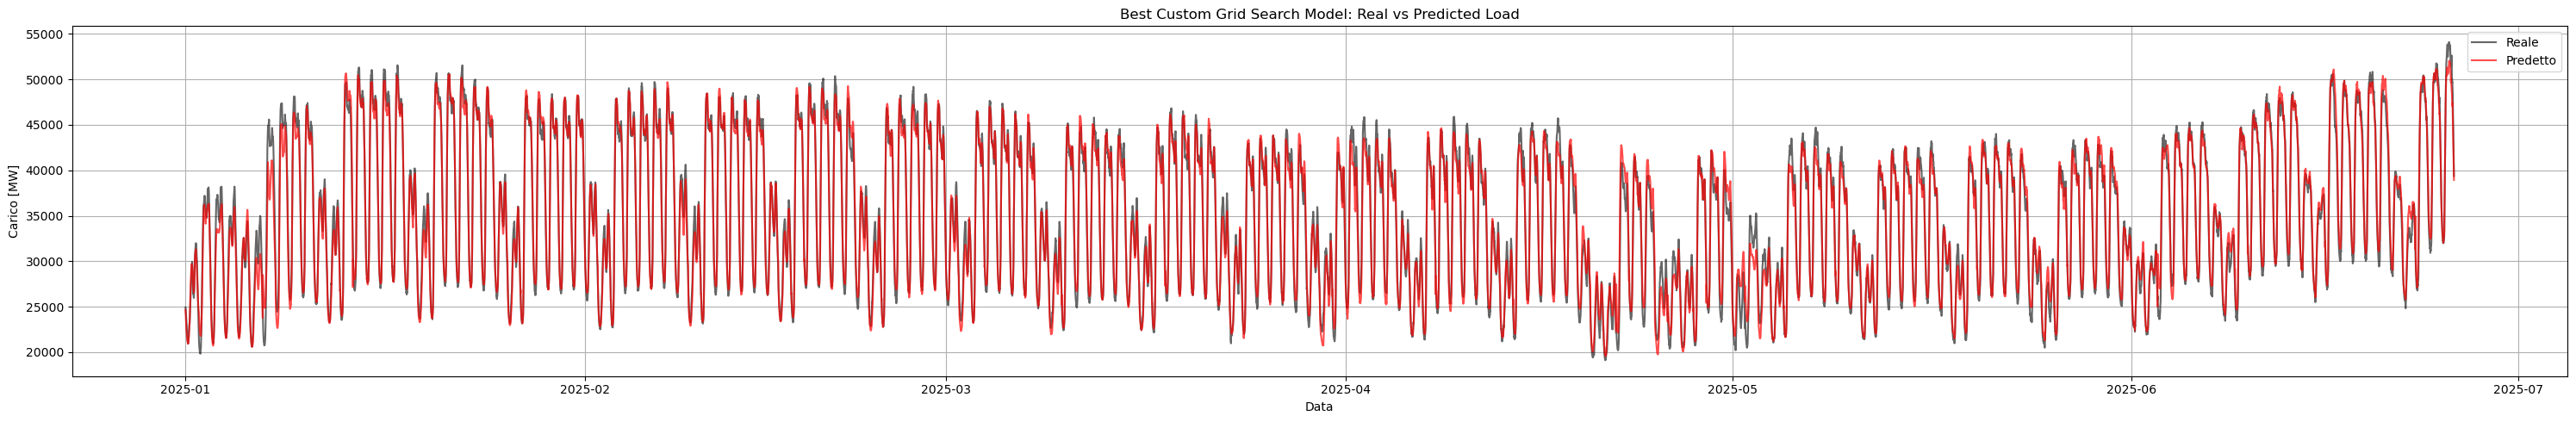

In [101]:
print("\nTraining set performance:")
print_eval(X_train_scaled, y_train, best_model, y_scaler)

print("\nTest set performance:")
print_eval(X_test_scaled, y_test, best_model, y_scaler)

plot_model_on_data(X_test_scaled, y_test, best_model, 
                   figsize=(30, 5), y_scaler=y_scaler, 
                   title="Best Custom Grid Search Model: Real vs Predicted Load")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step


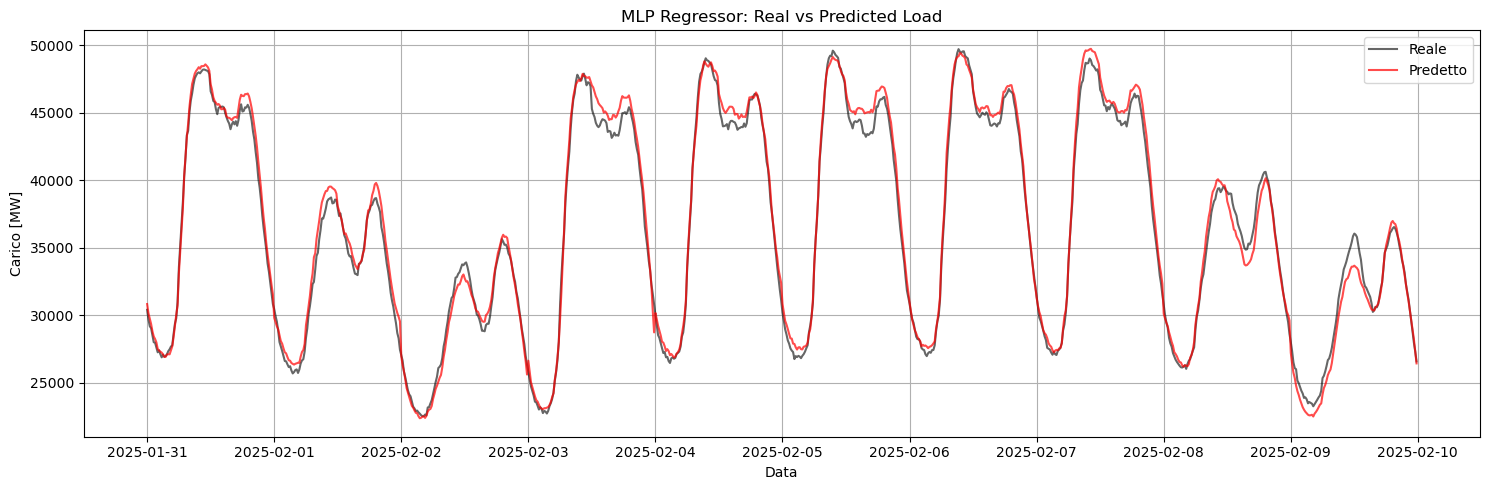

In [115]:
plot_model_on_data(X_test_scaled[2880:3840], y_test[2880:3840], best_model, figsize=(15, 5),y_scaler=y_scaler, title="MLP Regressor: Real vs Predicted Load")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


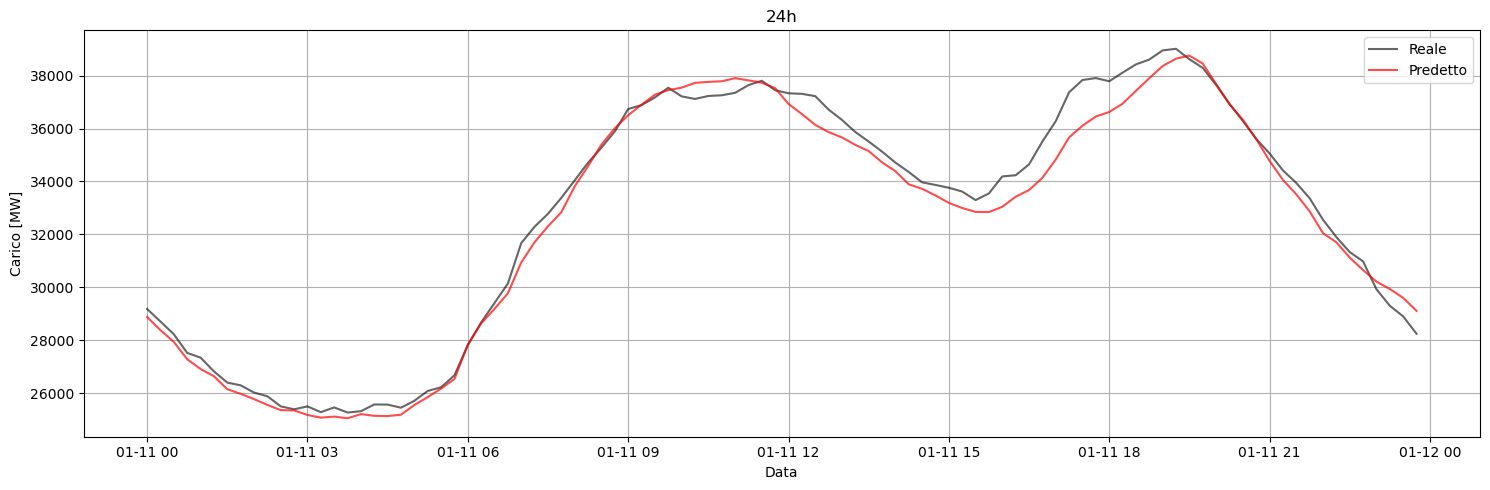

In [112]:
plot_model_on_data(X_test_scaled[960:1056], y_test[960:1056], best_model, y_scaler=y_scaler, title="24h")